In [1]:
import numpy as np

data = np.load('data/tox21_graph.npz')
atom_feat_tr = data['atom_feat_tr']
atom_feat_val = data['atom_feat_val']
atom_feat_te = data['atom_feat_te']

edge_feat_tr = data['edge_feat_tr']
edge_feat_val = data['edge_feat_val']
edge_feat_te = data['edge_feat_te']

y_tr = data['y_tr']
y_val = data['y_val']
y_te = data['y_te']

y_notnan_tr = data['y_notnan_tr']
y_notnan_val = data['y_notnan_val']
y_notnan_te = data['y_notnan_te']

print(atom_feat_tr.shape, atom_feat_val.shape, atom_feat_te.shape)
print(edge_feat_tr.shape, edge_feat_val.shape, edge_feat_te.shape)
print(y_tr.shape, y_val.shape, y_te.shape)

(11758, 132, 63) (295, 132, 63) (645, 132, 63)
(11758, 132, 132, 5) (295, 132, 132, 5) (645, 132, 132, 5)
(11758, 12) (295, 12) (645, 12)


In [2]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from functools import partial
from ggnnmols.models import GGNN


node_dim = atom_feat_tr.shape[-2]
node_feat_dim = atom_feat_tr.shape[-1]
edge_feat_dim = edge_feat_tr.shape[-1]
hidden_size = 512
output_dim = y_tr.shape[-1]
num_prop = 10

model = GGNN(node_dim, node_feat_dim, edge_feat_dim, hidden_size, output_dim, num_prop=num_prop, missing_ys=True)
node_inputs = tf.keras.layers.Input(shape=atom_feat_tr.shape[1:])
edge_inputs = tf.keras.layers.Input(shape=edge_feat_tr.shape[1:])
valid_y_inputs = tf.keras.layers.Input(shape=y_tr.shape[-1:])
outputs = model([node_inputs, edge_inputs, valid_y_inputs])

def valid_binary_crossentropy(y_true, y_pred, valid_y):
    return K.sum(K.binary_crossentropy(y_true, y_pred) * valid_y, axis=-1)

def valid_acc(y_true, y_pred, valid_y):
    eq_all = K.cast(K.equal(y_true, K.round(y_pred)), K.floatx())
    return K.sum(eq_all * valid_y) / K.sum(valid_y)

bxen = partial(valid_binary_crossentropy, valid_y=valid_y_inputs)
acc = partial(valid_acc, valid_y=valid_y_inputs)
acc.__name__ = 'acc'

optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=bxen, metrics=[acc])

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
model.load_weights("weights.best.hdf5")

In [4]:
model.evaluate(x=[atom_feat_te, edge_feat_te, y_notnan_te], y=y_te, batch_size=16, verbose=1)

645/645 [==============================] - 6s 10ms/sample - loss: 2.1589 - acc: 0.9290


[2.158878186691639, 0.9289854]

In [5]:
p = model.predict([atom_feat_te, edge_feat_te, y_notnan_te], batch_size=16)

In [6]:
ps = []
ys = []
for label in range(y_te.shape[-1]):
    index = y_notnan_te[:, label].astype(bool)
    ps.append(p[index,label])
    ys.append(y_te[index,label])

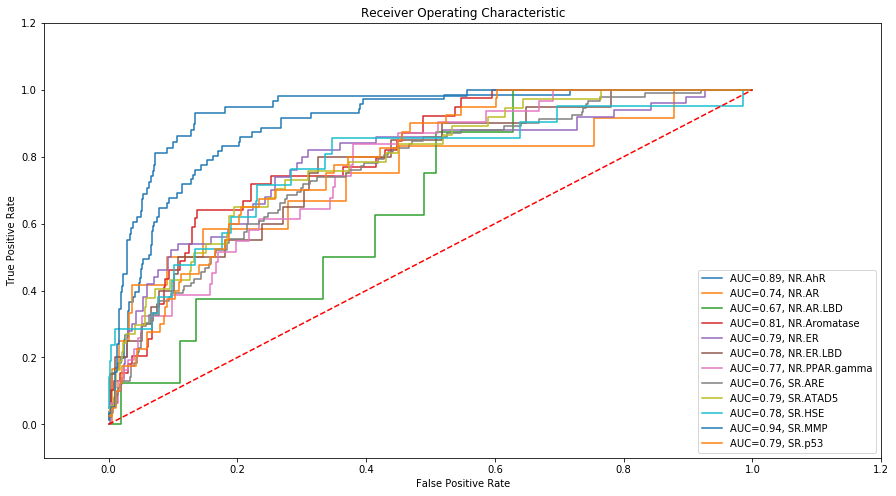

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

tox21_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']
fig = plt.figure(figsize=(15,8))
for i in range(len(ps)):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(ys[i], ps[i])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, label='AUC={:.2f}, {}'.format(roc_auc, tox21_labels[i]))
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()